See accompanying slides [here](https://github.com/jhelie/mcmc/blob/main/slides.pdf).

To run this notebook you just need to be able to import the packages below (everything is local - no remote dataset or API).

In [1]:
import emcee
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

---

# MCMC: the basics

---

## Metropolis algorithm

Let's suppose we want to draw samples from the following distribution - or simply find out what it looks like:

$$f(x)=\exp \left( -\frac{x-7.5}{11.2} - \exp \left( -\frac{x-7.5}{11.2} \right) \right)$$

This is actually a right-skewed [Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution), which is included in `scpiy.stats`. But let's pretend we don't know that and let's use MCMC. Below is a very naive implementation of the Metropolis algorithm that uses a **normal distribution as proposal density**:

In [2]:
def mcmc(f, chain_length, chain_start, proposal_width=0.5):
    """
    Naive implementation of the Metropolis algorithm using a normal distribution as proposal density.

    Parameters
    ----------
    f : callable
    A function proportional to the distribution we want to draw samples from.
    chain_length : int
    Number of iterations to run.
    chain_start : int
    Initial starting value of the chain.
    proposal_width : float
    Standard deviation of the Normal distribution used as proposal distribution.

    Returns
    -------
    chain : [float]
    The MCMC chain built, i.e. the sequence of accepted values.
    rate : float
    The acceptance rate of proposed values.
    """
    # keep track of the number of proposed values that end up being accepted
    n_accepted = 0

    # initialise chain
    current = chain_start
    chain = [current]

    # grow chain
    for i in range(chain_length):
        # using proposal dist randomly generate proposed value close to current value
        proposed = scipy.stats.norm(current, proposal_width).rvs(1)[0]

        # compute "probabilities" for current and proposed values
        # ("probabilities" as these are not actual probabilities since the function is not normalised to integrate to 1 - but we don't care since we're interested in the ratio)
        p_current = f(current)
        p_proposed = f(proposed)

        # accept proposed value with probability p_proposed / p_current
        if scipy.stats.uniform(0, 1).rvs(1)[0] < p_proposed / p_current:
            current = proposed
            n_accepted += 1

        # update trace
        chain.append(current)

    # compute the acceptance rate
    rate = n_accepted/(chain_length-1)
    return chain, rate

In [3]:
def f(x):
    z = (x - 7.5)/11.2
    return np.exp(-(z + np.exp(-z)))

Let's run the chain for 20,000 iterations starting at the (arbitrarily chosen) value of `0`:

In [4]:
chain_s0_w30, rate_s0_w30 = mcmc(f, chain_length=20000, chain_start=0, proposal_width=30)

Let's look at the trace we get:

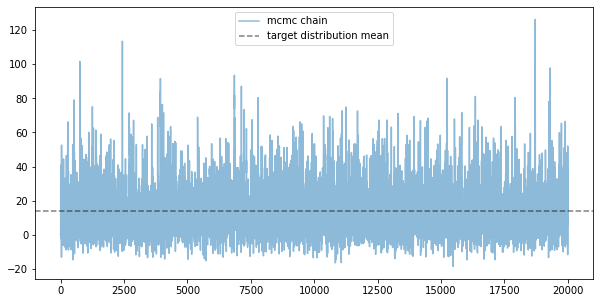

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(np.arange(len(chain_s0_w30)), chain_s0_w30, alpha=0.5, label='mcmc chain')
ax.axhline((7.5 + 11.2 * np.euler_gamma), c='k', alpha=0.5, linestyle='--', label='target distribution mean')
ax.legend()

And let's compare the distribution of the values in that chain to the actual pdf (using scipy):

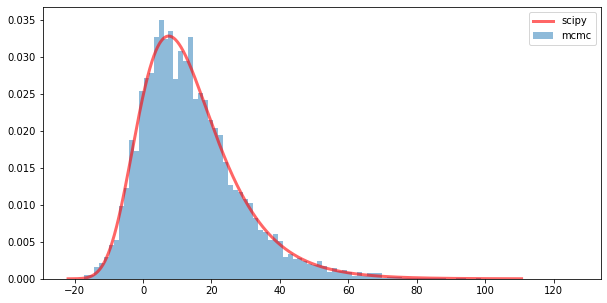

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
# scipy
g = scipy.stats.gumbel_r(7.5, 11.2)
x = np.linspace(g.ppf(0.000001), g.ppf(0.9999), 1000)
ax.plot(x, g.pdf(x), 'r-', lw=3, alpha=0.6, label='scipy')
# mcmc
ax.hist(chain_s0_w30, 100, density=True, alpha=0.5, label='mcmc')
ax.legend()

That's pretty nice.

---

## Influence of the initial chain value

Let's see what happens if our initial guess is widly away from the high density region of our target. We use the same code as before but this time set `chain_start=1000`:

In [7]:
# for demo purpose let's also change the proposal width to something smaller, see note at the end of the section for details
chain_s1000_w3, _ = mcmc(f, chain_length=20000, chain_start=1000, proposal_width=3)

Let's have a look at that new chain:

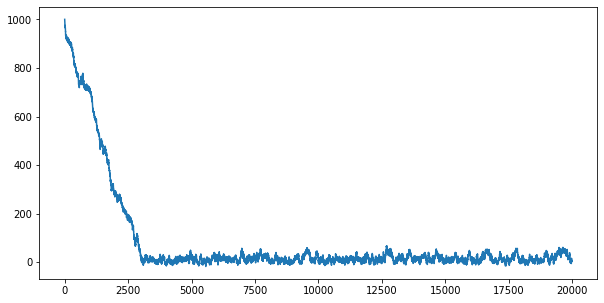

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(np.arange(len(chain_s1000_w3)), chain_s1000_w3)

And the corresponding dist:

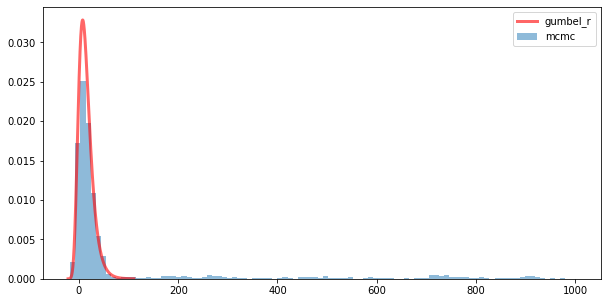

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
g = scipy.stats.gumbel_r(7.5, 11.2)
x = np.linspace(g.ppf(0.000001), g.ppf(0.9999), 1000)
ax.hist(chain_s1000_w3, 100, density=True, alpha=0.5, label='mcmc')
ax.plot(x, g.pdf(x), 'r-', lw=3, alpha=0.6, label='gumbel_r')
ax.legend()

From the trace the chain only seems to become stationary after the first ~3500 values, so let's discard those:

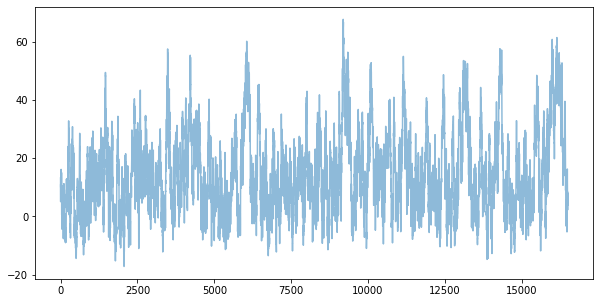

In [10]:
burn_in = 3500
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(np.arange(len(chain_s1000_w3[burn_in:])), chain_s1000_w3[burn_in:], alpha=0.5)

And again let's compare the distribution of the values in that sub-chain to the actual pdf (using scipy):

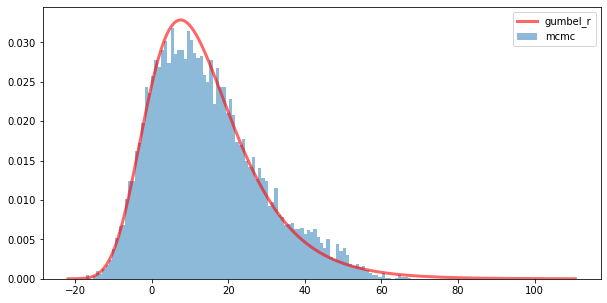

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
g = scipy.stats.gumbel_r(7.5, 11.2)
x = np.linspace(g.ppf(0.000001), g.ppf(0.9999), 1000)
ax.hist(chain_s1000_w3[burn_in:], 100, density=True, alpha=0.5, label='mcmc')
ax.plot(x, g.pdf(x), 'r-', lw=3, alpha=0.6, label='gumbel_r')
ax.legend()

Much better.

**Note**: in the above we also reduced the proposal width from 30 to 3. This was to make it easier to identify the burn-in period. Indeed, the plot below shows in red what happens with a proposal width of 30: that width is so "good" for the problem that we almost immediately recover from our outlandish initial value.

This is an important point: with MCMC you don't care that much about where you start your chain, what matters is getting the proposal width "right".

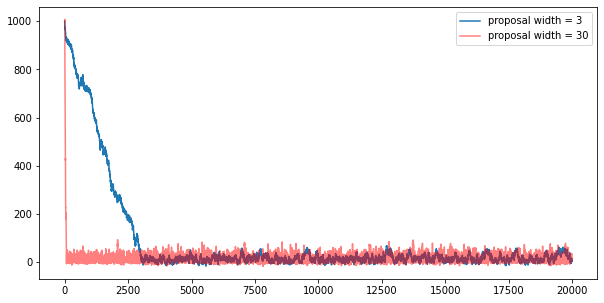

In [12]:
chain_s1000_w30, _ = mcmc(f, chain_length=20000, chain_start=1000, proposal_width=30)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(np.arange(len(chain_s1000_w3)), chain_s1000_w3, label='proposal width = 3')
ax.plot(np.arange(len(chain_s1000_w30)), chain_s1000_w30, c='r', alpha=0.5, label='proposal width = 30')
ax.legend()

---

## Influence of the proposal width

Let's run our sampler using the same initial value (`0`), the same number of steps but different proposal widhts:

In [13]:
chain_s0_w1000, rate_s0_w1000 = mcmc(f, chain_length=20000, chain_start=0, proposal_width=1000)
chain_s0_w05, rate_s0_w05 = mcmc(f, chain_length=20000, chain_start=0, proposal_width=0.5)

Let's look at the traces:

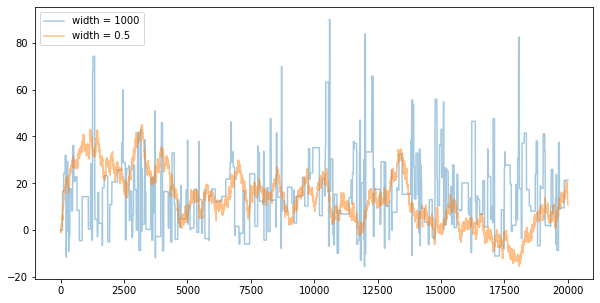

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(np.arange(len(chain_s0_w1000)), chain_s0_w1000, alpha=0.4, label='width = 1000')
ax.plot(np.arange(len(chain_s0_w05)), chain_s0_w05, alpha=0.5, label='width = 0.5')
ax.legend()

And how their distributions compare to the target distribution:

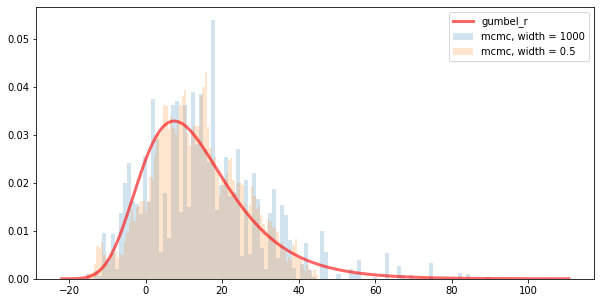

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
g = scipy.stats.gumbel_r(7.5, 11.2)
x = np.linspace(g.ppf(0.000001), g.ppf(0.9999), 1000)
ax.hist(chain_s0_w1000, 100, density=True, alpha=0.2, label='mcmc, width = 1000')
ax.hist(chain_s0_w05, 100, density=True, alpha=0.2, label='mcmc, width = 0.5')
ax.plot(x, g.pdf(x), 'r-', lw=3, alpha=0.6, label='gumbel_r')
ax.legend()

We can see the sampling is not fantastic:
- **proposal width too small**: we never jump very far so we almost always accept the proposed value (since `p_proposed / p_current` is almost always ~1) but we explore the space very slowly as it takes time to cover ground.

In [16]:
rate_s0_w05

0.9881994099704985

- **proposal width too large**: we always jump quite far, so could move to different parts of the space in a few steps, but we rarely accept any proposed value because the proposed value almost always land in low density area (and so `p_proposed / p_current` is << 1).

In [17]:
rate_s0_w1000

0.01670083504175209

Unfortunately, while very small and very high values are always bad, there is no unique optimum value for the acceptance rate. Under some specific assumptions it might be possible to show what is the best theoretical acceptance rate to aim for, but generally it will depend on the problem. Typically a particular MCMC technique will state that the acceptance should be between "x% and y%".

---

## Chain thinning

Let's look at the [autocorrelation plots](https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm) for the 3 chains `chain_s0_w30`, `chain_s0_w05` and `chain_s0_w1000`:

In [18]:
def show_acf(chains, labels=None, lags=1000, burn_in=0, ci=None, thinning=1):
    if labels is None:
        labels = [f'chain {i+1}' for i in range(len(chains))]
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    colors = plt.rcParams['axes.prop_cycle']()
    for i, chain in enumerate(chains):
        plot_acf(chain[burn_in::thinning], ax=ax, lags=lags, alpha=ci, use_vlines=False, marker='.', label=labels[i], c=next(colors)['color'])
    ax.axhline(0, c='k', alpha=0.5, linestyle='--')
    ax.legend()
    ax.set_xlabel('lag', fontsize='x-large')

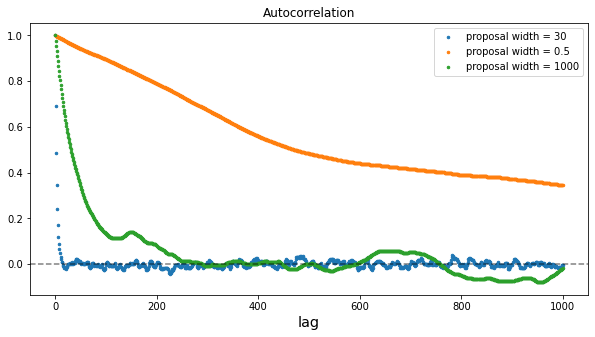

In [19]:
show_acf([chain_s0_w30, chain_s0_w05, chain_s0_w1000], ['proposal width = 30', 'proposal width = 0.5', 'proposal width = 1000'], burn_in=3500)

*Note: to simply illustrate the point we're wilfully ignoring the question of whether the same burn-in period is adequate for all chains.*

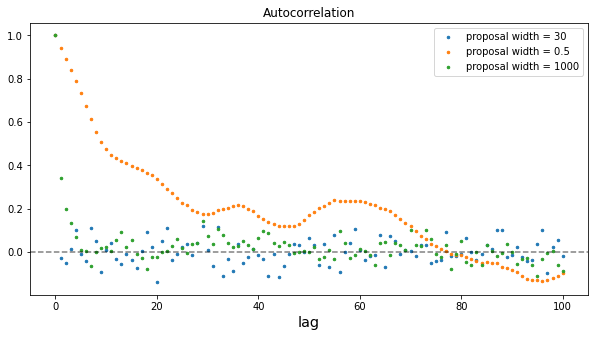

In [20]:
show_acf([chain_s0_w30, chain_s0_w05, chain_s0_w1000], ['proposal width = 30', 'proposal width = 0.5', 'proposal width = 1000'], burn_in=3500, lags=100, thinning=50)

We can see that:
- consecutive values in a chain are correlated
- the extent of that correlation depends on the proposal distribution's width
- if we thin the chain enough we can get independent "consecutive" values

**Note:** thinning cannot replace an adequate proposal width - the more we thin the less efficient the mcmc sampler. It is just something we may need to do if we need to generate n-independent values for the target dist.

---

# MCMC: multivariate targets

---

Now let's assume that the distribution we'd like to sample is multivariate. For instance a multivariate normal:

$$f(x) = \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)$$

As a reminder, using a bivariate dist:
- $x=(x_{1}, x_{2})$
- $\mu = \begin{pmatrix} \mu_{1} \\ \mu_{2} \end{pmatrix}$ means along each dimension
- $\Sigma = \begin{pmatrix} \sigma_{1}^{2} & \rho_{12}\sigma_{1}\sigma_{2} \\ \rho_{12}\sigma_{1}\sigma_{2} & \sigma_{2}^{2} \end{pmatrix}$ covariance matrix

$$f(x) = \exp\left(-\frac{1}{2(1-\rho^{2})}\left[ \left(\frac{x_{1} - \mu_{1}}{\sigma_{1}}\right)^2  - 2 \rho \left(\frac{x_{1} - \mu_{1}}{\sigma_{1}}\right) \left(\frac{x_{2} - \mu_{2}}{\sigma_{2}}\right) + \left(\frac{x_{2} - \mu_{2}}{\sigma_{2}}\right)^2  \right] \right)$$

And this is what such a distibution looks like:

In [21]:
# let's center x1 on 37 and x2 on -13
means = [37, -13]

# let's make x1 quite narrow and x2 quite spread, and correlate the two 
cov_matrix = [[5, 15], [15, 57]]

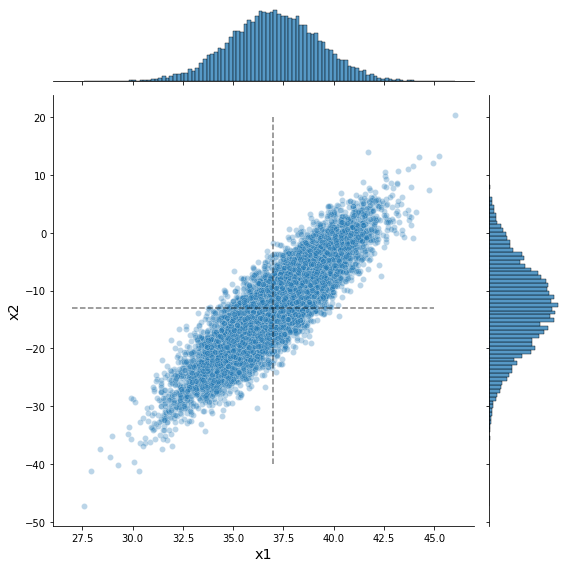

In [22]:
data = scipy.stats.multivariate_normal(means, cov_matrix).rvs(10000)
h = sns.jointplot(x=data[:,0], y=data[:,1], alpha=0.3, marginal_kws={'bins':100}, height=8)
h.ax_joint.set_xlabel('x1', fontsize='x-large')
h.ax_joint.set_ylabel('x2', fontsize='x-large')
h.ax_joint.hlines(means[1], 27, 45, 'k', '--', alpha=0.5)
h.ax_joint.vlines(means[0], -40, 20, 'k', '--', alpha=0.5)
plt.tight_layout()

---

## Block-wise Metropolis

We can apply exactly the same MH (Metropolis-Hasting) algorithm as before, except this time using a 2D proposal dist.

*Note: for numerical reasons it's best to work with `log(f)` (instead of `f`) in order to be able to return non-zero probabilities values, even in low density areas. This is always true but even more so for multivariate distributions.*

In [23]:
def logf2d(x1, x2):
    m1 = means[0]
    m2 = means[1]
    s1 = np.sqrt(cov_matrix[0][0])
    s2 = np.sqrt(cov_matrix[1][1])
    rho =  cov_matrix[0][1] / (s1*s2)
    return -(1/(2*(1 - rho**2)))*(((x1 - m1)/s1)**2 - 2*rho*((x1 - m1)/s1)*((x2 - m2)/s2) + ((x2 - m2)/s2)**2)

Of course we could use scipy to conveniently define `logf2d` as follows:

```python
def logf2d(x1, x2):
    s = scipy.stats.multivariate_normal(means, cov_matrix)
    return s.logpdf([x1, x2])
```
But in a real case scenario, where `f` is an arbitratry multidimensional function, that wouldn't be possible (if it was there'd be no point in using MCMC!), so I'm sticking to the "manual" definition.

In [24]:
def mcmc_2d_block(logf, chain_length, chain_start, proposal_cov=None):
    n_accepted = 0
    if proposal_cov is None:
        proposal_cov = [[1, 0], [0, 1]]
    current = chain_start
    out = [current]
    for i in range(chain_length):
        # randomly generate new vector of values close to current vector of values using our 2D proposal width
        proposed = scipy.stats.multivariate_normal(current, proposal_cov).rvs(1)
        
        # compute "probabilities" for current and proposed values
        log_p_current = logf(*current)
        log_p_proposed = logf(*proposed)
        
        # accept proposed value with probability p_proposed / p_current
        if np.log(scipy.stats.uniform(0, 1).rvs(1)[0]) < log_p_proposed - log_p_current:
            current = proposed
            n_accepted += 1
        
        # update trace
        out.append(current)
    return np.array(out), n_accepted/(chain_length-1)

Let's run the chain for 10,000 steps - note that we need to specify a starting point in the 2D space and a covariant matrix for the proposal dist:

In [25]:
chain2d, rate2d = mcmc_2d_block(logf2d, chain_length=10000, chain_start=[-80, 27], proposal_cov=[[1,0],[0,10]])

Let's see what the chains looks like:

In [26]:
def show_chains_2d(chains, labels=None):
    if labels is None:
        labels = ['x1','x2']
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(np.arange(chains.shape[0]),chains[:,0], label=labels[0])
    ax.plot(np.arange(chains.shape[0]),chains[:,1], label=labels[1])
    ax.legend()

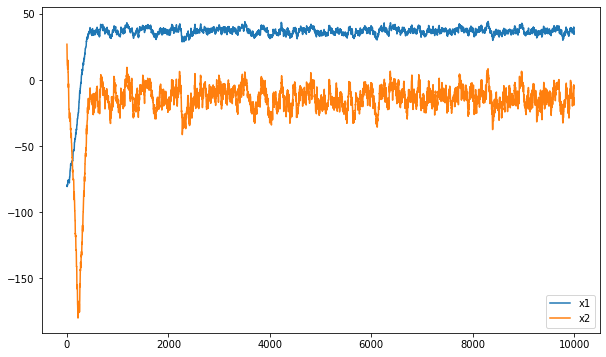

In [27]:
show_chains_2d(chain2d)

And let's compare the resulting distribution with the truth:

In [28]:
def add_bivariate_norm_truth(chain, mean=[37, -13], cov=[[5, 15], [15, 57]], n_truth=10000):
    """
    Create a DataFrame that can be processed by seaborn.joinplot to produce scatter plot of the data with
    marginal histograms for both the chain and the corresponding truth.
    """
    # mcmc data
    df_mcmc = pd.DataFrame(chain, columns=['x1','x2'])
    df_mcmc['method'] = 'mcmc'

    # truth data
    truth = scipy.stats.multivariate_normal(mean, cov)
    df_scipy = pd.DataFrame(truth.rvs(n_truth), columns=['x1','x2'])
    df_scipy['method'] = 'scipy'
    
    return pd.concat([df_mcmc, df_scipy])

In [29]:
def show_hist_2d(chains):
    df = add_bivariate_norm_truth(chains)
    h = sns.jointplot(data=df, x='x1', y='x2', alpha=0.1, hue='method', height=8)
    h.ax_joint.set_xlabel('x1')
    h.ax_joint.set_ylabel('x2')
    plt.tight_layout()

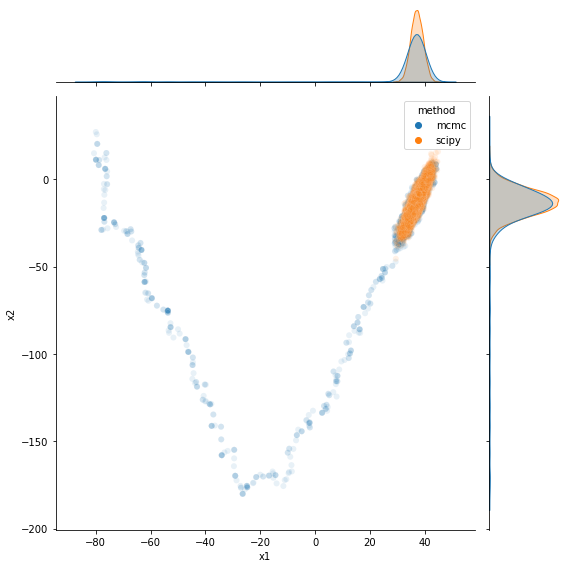

In [30]:
show_hist_2d(chain2d)

In [31]:
rate2d

0.6027602760276027

That's not too bad! But what if we had used a slightly different covariance matrix?

In [32]:
chain2d2, rate2d2 = mcmc_2d_block(logf2d, chain_length=10000, chain_start=[-80, 27], proposal_cov=[[1,0],[0,0.1]])

If we look at the chains we can tell that the mixing on `x2` doesn't seem to be too good:

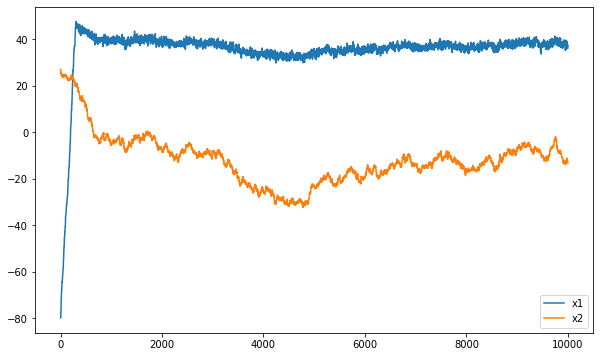

In [33]:
show_chains_2d(chain2d2)

And indeed the histogram is not as good:

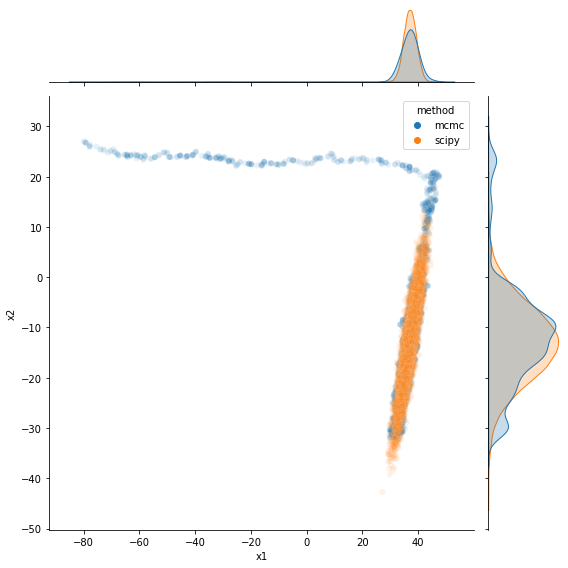

In [34]:
show_hist_2d(chain2d2)

But the acceptance rate is not that much different from before: it's because unfortunately the acceptance rate is for the proposed vector as a whole, so it's hard to make much of it to improve our covariance matrix.

In [35]:
rate2d2

0.7036703670367037

Finding a suitable proposal dist, i.e. a suitable covariant matrix, is increasingly difficult as the number of dimensions increases.

---

## Component-wise Metropolis

The idea is simply to propose an update on just one dimension at a time, using a univariate proposal dist.

In [36]:
def mcmc_2d_single_component(logf, chain_length, chain_start, proposal_widths):
    n_accepted = [0, 0]
    current = chain_start
    out = [current]
    for i in range(chain_length):
        proposed = current.copy()
        for j in range(2): # 2 since bivariate distribution, general case is n
            # suggest update in one dimension only
            proposed_j = scipy.stats.norm(current[j], proposal_widths[j]).rvs(1)[0]
            proposed[j] = proposed_j
        
            # compute "probabilities" for current and proposed values
            log_p_current = logf(*current)
            log_p_proposed = logf(*proposed)
            
            # accept proposed value with probability p_proposed / p_current
            if np.log(scipy.stats.uniform(0, 1).rvs(1)[0]) < log_p_proposed - log_p_current:
                current = proposed.copy()
                n_accepted[j] += 1
            else:
                proposed = current.copy()
        
        # update trace
        out.append(current)
    return np.array(out), np.array(n_accepted)/(chain_length-1)

In [37]:
chain2dsc, ratessc = mcmc_2d_single_component(logf2d, chain_length=10000, chain_start=[-80, 27], proposal_widths=[1, 0.1])

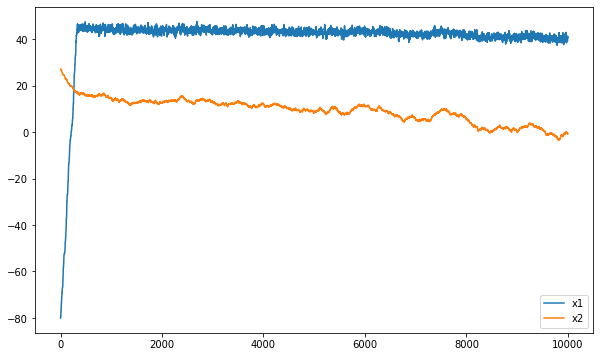

In [38]:
show_chains_2d(chain2dsc)

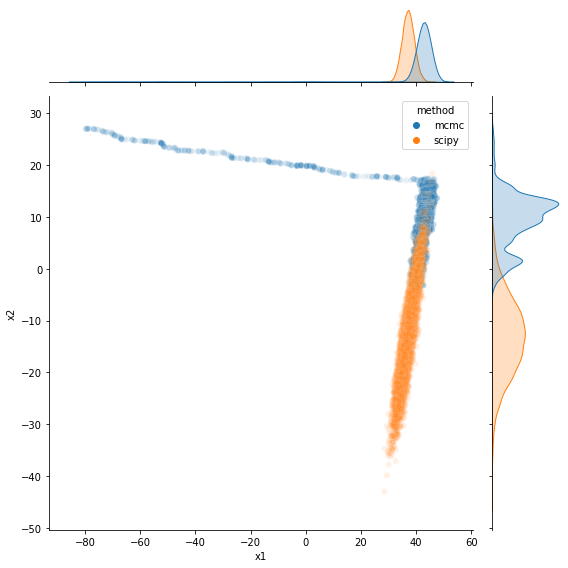

In [39]:
show_hist_2d(chain2dsc)

The results aren't great but now we have access to the acceptance rate in each dimension and it seems that our acceptance rate along x2 is way too high meaning our proposal width in this dimension is too small: we should increase it progressively and check how things improve. For instance try using `10` instead of `0.1`.

In [40]:
ratessc

array([0.70847085, 0.97729773])

This approach is:
- generally more efficient
- provides a simple way to adjust the proposal_dist in each dimension by looking at the acceptance rates
- provides a simpler way to propose candidates (drawing from univariate distributions rather than a multivariate one)

At least in theory, this approach provides a way to use MCMC to sample any multivariate distribution given only the knowledge of drawing from a univariate distribution.

---

## Gibbs sampling

This is exactly the same idea as the above single component algorithm except that:
- we use the conditional distribution of each variable as its proposal distibution.
- we accept each proposed update

This is more efficient. The math says so but it's also intuitive:
- with "naive" component wise sampling we always use the same proposal distribution (with a fixed width) to propose a new value randomly and we then ask "how good is it now?" in order to decide whether to accept it
- with Gibbs sampling we directly sample from a distribution that depends on where we currently and but will give us the "right" values to sample the dimension of interest (so no more need to check whether we should keep the proposed values).

For a bivariate normal distribution the conditional distribution of `x1` given `x2` is the following univariate normal distribution:

$$p(x_{1}|x_{2}) \sim N\left(\mu_{1} + \frac{\sigma_{1}}{\sigma_{2}}\rho(x_{2}-\mu_{2}), (1 - \rho)\sigma_{1}^{2}\right)$$

And likewise for $p(x_{2}|x_{1})$.

In [41]:
def f2d_x1condx2(x2, n):
    mean = [37, -13]
    cov = [[5, 15], [15, 57]]
    m1 = mean[0]
    m2 = mean[1]
    s1 = np.sqrt(cov[0][0])
    s2 = np.sqrt(cov[1][1])
    rho = cov[0][1]/(s1*s2)
    return scipy.stats.norm(m1 + (s1/s2)*rho*(x2 - m2), (1-rho)*s1**2).rvs(n)

In [42]:
def f2d_x2condx1(x1, n):
    mean = [37, -13]
    cov = [[5, 15], [15, 57]]
    m1 = mean[0]
    m2 = mean[1]
    s1 = np.sqrt(cov[0][0])
    s2 = np.sqrt(cov[1][1])
    rho = cov[0][1]/(s1*s2)
    return scipy.stats.norm(m2 + (s2/s1)*rho*(x1 - m1), (1-rho)*s2**2).rvs(n)

To make it a bit more concrete below is a plot showing that the conditional distribution is for a dimension (in orange) when the other is the other dimension is fixed.

In [43]:
def show_gibbs(dimension='x1', x1_fixed=37, x2_fixed=0):
    if dimension not in ['x1','x2']:
        raise ValueError('dimension should be either "x1" or "x2".')

    # get sample from true dist using scipy
    data = scipy.stats.multivariate_normal([37, -13], [[5, 15], [15, 57]]).rvs(5000)
    df_bivariate = pd.DataFrame(data, columns=['x1','x2'])
    df_bivariate['method'] = 'bivariate dist'

    if dimension == 'x1':
        # get data corresponding to conditional p(x1|x2=0)
        d = np.zeros((1000,2))
        d[:,0] = f2d_x1condx2(x2=x2_fixed, n=1000)
        d[:,1] = x2_fixed
        df_x = pd.DataFrame(d, columns=['x1','x2'])
        df_x['method'] = 'x1 |x2'
    else:
        # get data corresponding to conditional p(x2|x1=0)
        d = np.zeros((1000,2))
        d[:,0] = x1_fixed
        d[:,1] = f2d_x2condx1(x1=x1_fixed, n=1000)
        df_x = pd.DataFrame(d, columns=['x1','x2'])
        df_x['method'] = 'x2 |x1'

    df_gibbs = pd.concat([df_bivariate, df_x])
    
    # plot data
    h = sns.jointplot(data=df_gibbs, x='x1', y='x2', alpha=0.3, hue='method', height=8)
    h.ax_joint.set_xlabel('x1')
    h.ax_joint.set_ylabel('x2')
    
    if dimension == 'x1':
        h.ax_joint.hlines(x2_fixed, 20, 55, 'g', '--')
    else:
        h.ax_joint.vlines(x1_fixed, -45, 25, 'g', '--')
    plt.tight_layout()

/Users/jhelie/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


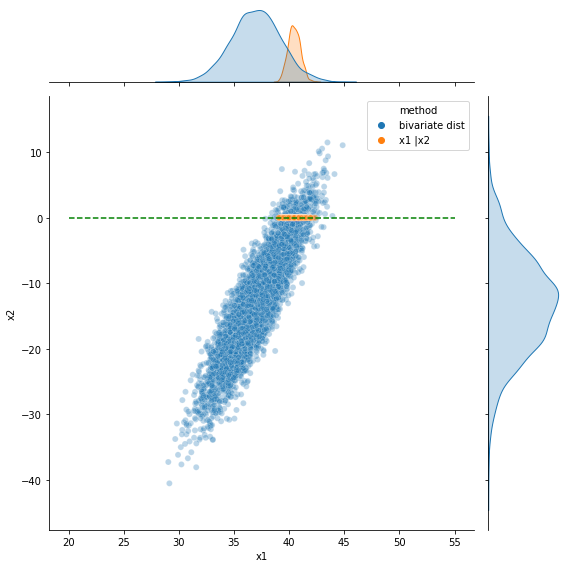

In [44]:
show_gibbs(dimension='x1')

Now let's implement a Gibbs sampler and run it:

In [45]:
def mcmc_2d_gibbs(f_x1condx2, f_x2condx1, chain_length, chain_start):
    current = chain_start
    out = [current]
    for i in range(chain_length):
        proposed = current.copy()
        # update x1: no acceptance criteria needed as our proposed value is drawn from p(x1|x2) and always accepted
        proposed[0] = f_x1condx2(x2=proposed[1], n=1)[0]

        # update x2: no acceptance criteria needed as our proposed value is drawn from p(x2|x1) and always accepted
        proposed[1] = f_x2condx1(x1=proposed[0], n=1)[0]
        
        # update trace
        out.append(proposed)
        current = proposed.copy()
    return np.array(out)

In [46]:
chain_gibbs = mcmc_2d_gibbs(f2d_x1condx2, f2d_x2condx1, chain_length=10000, chain_start=[-80, 27])

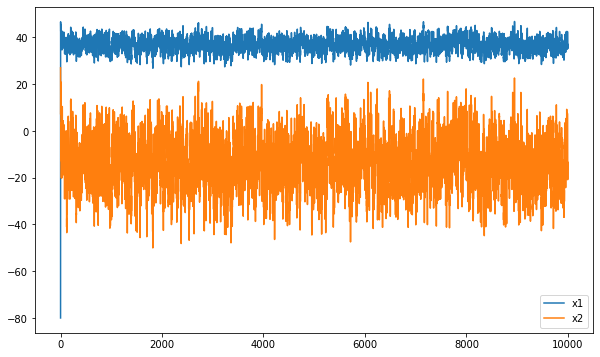

In [47]:
show_chains_2d(chain_gibbs)

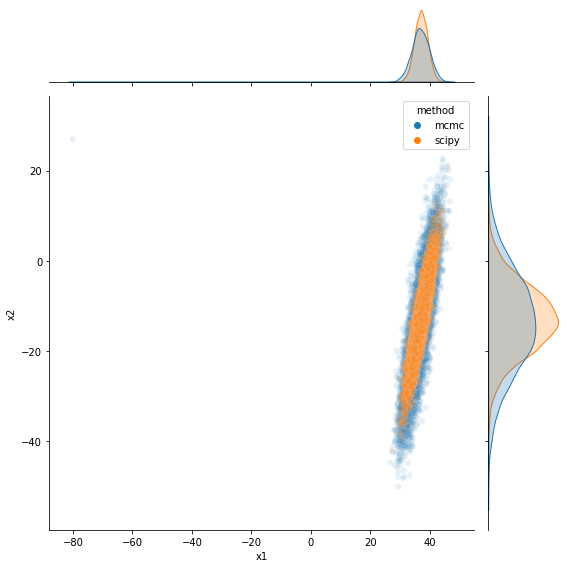

In [48]:
show_hist_2d(chain_gibbs)

Very nice: using the same initial guess and the same number of steps the Gibbs yield a much better sampling of our target dist and without the need to fiddle with proposal width/covariance!

The catch is that... we must be able to sample from the conditional distribution of each variable, and just because it's univariate doesn't mean it's easy.

There are roughly 3 scenarios:
- the conditional has a nice analytical form we can sample from
- it's not quite a clean/known dist but we can approximate it by one
- neither of the above:  we use a standard MH-sampler for the conditional we can't directly draw from, i.e. we use an MCMC sampler within our MCMC sampler. See below for an implementation of such a [Hybrid Gibbs sampler](#Hybrid-Gibbs-sampler) (also known as Metropolis-within-Gibbs)

Fially another issue with Gibbs sampling is if the parameters are highly correlated: then the sampler plays ping-pong without making much progress. 

---

# MCMC and Bayesian statistics

---

## Bayesian notions: reminders

We use $\theta$ refers to the parameter vector, $data$ to refer to the whole of the observed data and $x$ to refer a single new data point (see the [wiki page on Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference#Formal_description_of_Bayesian_inference) for details).

- likelihood (model): $p(data|\theta)$
- prior: $p(\theta)$
- prior predictive: $p(x) = \int p(x|\theta)*p(\theta)d\theta$

Having observed $data$, we are interested in estimating the following distributions:
- posterior: $p(\theta|data)$
- posterior predictive: $p(x|data) = \int p(x|\theta)*p(\theta|data)d\theta$

---

## Computing posterior distributions

According to Bayes' rule:

$$p(\theta|data) = \frac{p(data|\theta) * p(\theta)}{p(data)}$$

i.e. $p(\theta|data) \sim p(data|\theta) * p(\theta)$ since $p(data)$ is a constant.

In other words: to compute the posterior distribution $p(\theta|data)$ we can use MCMC with a function $f(\theta) \sim p(data|\theta)*p(\theta)$.

### Model

Let's take and example and let's say we're observing the following data:

In [49]:
def something_that_generates_data(n):
    s = scipy.stats.norm(13, 24).rvs(n)
    s += scipy.stats.uniform(-1,0).rvs(n) # this is Uniform distribution on [-1,0], with mean -0.5
    return s

<AxesSubplot:ylabel='Count'>

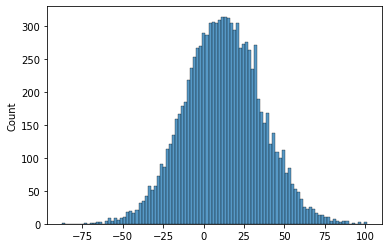

In [50]:
bayes_data = something_that_generates_data(10000)
sns.histplot(bayes_data, bins=100)

In [51]:
np.mean(bayes_data)

12.062939852521493

In [52]:
np.std(bayes_data)

23.792441743247966

We'd like to model the process that generates this data, and it looks like a normal might be a good model:

$$data \sim N(\mu,\sigma)$$

So we have two parameters: $\theta = [\mu, \sigma]$.

### Case 1: $\sigma$ known

In this scenario we assume we know $\sigma$ (actually we assume that we know that the data is generated from a normal distribution _and_ that we know what the standard deviation of that distribution is) and we'd like to gain information about probable values of $\mu$ based on some prior belief and the observed data.

Let's say a normal prior for $\mu$ is consistent with our belief: 

$$p(\mu) = N(\mu_{0},\sigma_{0})$$

and that, for whatever reasons, our prior belief suggests $\mu_{0}=30$ and $\sigma_{0}=3$.

We want to estimate the posterior distribution of $\mu$:

$$p(\mu | data, \sigma) \sim p(data|\mu,\sigma)*p(\mu)$$

Because both $p(data|\mu,\sigma)$ and $p(\mu)$ are Normal they're [conjugate](https://en.wikipedia.org/wiki/Conjugate_prior) to each other and the resulting dist is also a Normal dist:

$$p(\mu|\sigma, data) \sim N(\mu_{1},\sigma_{1})$$

where, with $n$ =len(data) and $<data>$ = mean(data):

$$\begin{eqnarray} \sigma_{1}^{2} &=& \left(\frac{1}{\sigma_{0}^{2}} + \frac{n}{\sigma^{2}}\right)^{-1} \\ \mu_{1} &=& \sigma_{1}^{2}\left(\frac{\mu_{0}}{\sigma_{0}^{2}} + \frac{n<data>}{\sigma^{2}}\right)\end{eqnarray}$$


**No need for MCMC**, we can estimate the posterior distribution directly, since it's a normal with known parameters.

In [53]:
def mu_posterior_sample(data, sigma, m0, s0, size):
    n = len(data)
    s1 = np.sqrt(1/(1/s0**2  + n/sigma**2))
    m1 = s1**2*(m0/s0**2 + n*np.mean(data)/sigma**2)
    return scipy.stats.norm(m1, s1).rvs(size)

But, just to convince ourselves that MCMC would work too, let's also try it (and compare its outcome to the above analytical solution). Our MCMC target function is:

$$\begin{eqnarray} f(\mu) &\sim& p(data|\mu,\sigma)*p(\mu|\mu_{0}, \sigma_{0}) \\ &=& \left[\prod_{x \in data}\exp\left(-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}\right)\right]* \exp\left(-\frac{1}{2}\left(\frac{\mu-\mu_{0}}{\sigma_{0}}\right)^{2}\right) \end{eqnarray}$$

And as before, we'll work with logs to avoid numerical issues when computing probabilities:

$$logf(\mu) = - \left[ \sum_{x \in data} \frac{x-\mu}{\sigma} \right] - \frac{1}{2}\left(\frac{\mu-\mu_{0}}{\sigma_{0}}\right)^{2}$$


In [54]:
def log_mu_posterior(mu, data, sigma):
    # P(data|proposed_mu, sigma)
    out = np.sum(scipy.stats.norm(mu, sigma).logpdf(data))

    # P(proposed_mu)
    out += scipy.stats.norm(loc=30, scale=3).logpdf(mu)
    return out

In [55]:
def mcmc_mu(logf, data, chain_length, chain_start, proposal_width=0.5):
    n_accepted = 0
    current = chain_start
    out = [current]
    for i in range(chain_length):
        # draw proposed mu from a norm centered on current mu
        proposed = scipy.stats.norm(current, proposal_width).rvs(1)[0]
        
        # compute log-probabilities for current and proposed mu values
        log_p_current = logf(current, data, sigma=24)
        log_p_proposed = logf(proposed, data, sigma=24)
    
        # accept proposed value with probability p_proposed / p_current
        if np.log(scipy.stats.uniform(0, 1).rvs(1)[0]) < log_p_proposed - log_p_current:
            current = proposed
            n_accepted += 1
        
        # update trace
        out.append(current)
    return np.array(out), n_accepted/(chain_length-1)

Let's run the chain and compare to the analytical posterior and the prior as more observations are available:

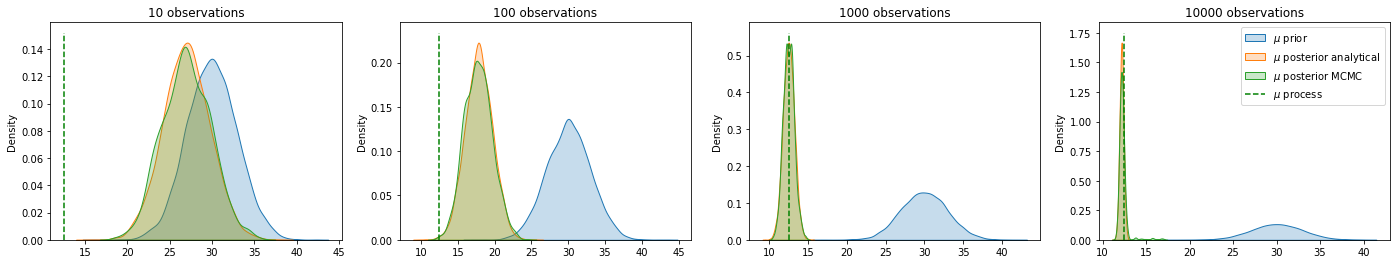

In [56]:
num_data = [10,100,1000,10000]
proposal_widths = [5,3,0.5,0.17]
fig, ax = plt.subplots(1,4, figsize=(24,4))
for i, n in enumerate(num_data):
    chain_mu, rate_mu = mcmc_mu(log_mu_posterior, bayes_data[:n], chain_length=2000, chain_start=30, proposal_width=proposal_widths[i])
    sns.kdeplot(x=scipy.stats.norm(loc=30, scale=3).rvs(10000), fill=True, label='$\mu$ prior', ax=ax[i])
    sns.kdeplot(x=mu_posterior_sample(bayes_data[:n], sigma=24, m0=30, s0=3, size=10000), fill=True, label='$\mu$ posterior analytical', ax=ax[i])
    sns.kdeplot(x=chain_mu[200:], fill=True, label='$\mu$ posterior MCMC', ax=ax[i])
    ax[i].vlines(12.5, *ax[i].get_ylim(), 'g', '--', label='$\mu$ process')
    ax[i].set_title(f'{n} observations')
    if i == len(num_data) - 1:
        ax[i].legend()

Note: all the previous caveats about choosing a "suitable" proposal density width still apply! A different proposal width was used for each different number of observations: this is because the target distribution, i.e. the posterior, changes and so does the best proposal width to sample that target. Of course in practice we don't know what a good proposal width would be for a given number of observations, so we'd have to look at the accpetance rate and iterate. Here I've just saved time by choosing every time a suitable proposal width in order to demonstrate that MCMC does give the same results as the analytical posterior.

Easy! That's why conjugate priors, if they make sense for the problem, are so nice.

### Case 2: $\mu$ known

This time we assume we know $\mu$ and we'd like to gain information about probable values of $\sigma$ based on some prior belief and the observed data, i.e. we want to estimate the posterior distribution of $\sigma$:

$$p(\sigma | \mu, data) \sim p(data|\mu,\sigma)*p(\sigma)$$

By definition $\sigma$ is > 0 so our prior should reflect that: let's choose a [Weibull](https://en.wikipedia.org/wiki/Weibull_distribution) distribution.

This means we have a Gaussian, $p(data|\mu,\sigma)$, and a Weibull distributions, $p(\theta)$, which I don't think are conjugate to each other, so while we can _compute_ $p(data|\mu,\sigma)*p(\sigma)$ we can't _sample_ from it.

**So we'll have to use MCMC.**

This means we need to define a proposal distribution and a proposal width. Let's say we have zero belief that $\sigma \lt 10$, we'll use a **truncated normal as our proposal dist** to ensure that all proposed values are > 10 for sigma (we don't have to, but it's a bit more efficient).

As before we'll use a function $f(\theta)$ that is proportional to $L(\sigma|\mu, data) = log[p(\sigma | \mu, data)]$ as our MCMC target function.

In [57]:
def log_sigma_posterior(sigma, data, mu, c, loc, scale):
    # this is only necessary to prevent emcee from crashing
    if sigma <= 0.:
        return -np.inf
    
    # P(data|mu, proposed_sigma)
    out = np.sum(scipy.stats.norm(mu, sigma).logpdf(data))

    # P(proposed_sigma)
    out += scipy.stats.weibull_min(c, loc=loc, scale=scale).logpdf(sigma)
    return out

Now we can just use a standard Metropolis-Hasting MCMC sampler to build our chain:

**Note**: since our proposal dist isn't symmetrical we must not forget to take this into account in the acceptance probability computation.

In [58]:
def mcmc_sigma(logf, data, chain_length, chain_start):
    n_accepted = 0
    current = chain_start
    out = [current]
    for i in range(chain_length):
        # draw proposed sigma from a truncated norm centered on current sigma
        proposed = scipy.stats.truncnorm(a=10.01 - current, b=np.inf, loc=current, scale=1).rvs(1)[0]
        
        # compute log-probabilities for current and proposed sigma values
        log_p_current = logf(current, data, mu=13, c=2, loc=10, scale=8)
        log_p_proposed = logf(proposed, data, mu=13, c=2, loc=10, scale=8)

        # account for asymmetry of proposal dist
        ppc = scipy.stats.truncnorm(a=10.01 - current, b=np.inf, loc=current, scale=1).logpdf(proposed)
        pcp = scipy.stats.truncnorm(a=10.01 - proposed, b=np.inf, loc=proposed, scale=1).logpdf(current)
    
        # accept proposed value with probability p_proposed / p_current
        if np.log(scipy.stats.uniform(0, 1).rvs(1)[0]) < (log_p_proposed + pcp - (log_p_current + ppc)):
            current = proposed
            n_accepted += 1
        
        # update trace
        out.append(current)
    return np.array(out), n_accepted/(chain_length-1)

Let's run the chain with an initial guess of $\sigma=17$ (using different amount of data to illustrate how the posterior diverges from the prior, as we did in case 1). And let's also use the `emcee` package to check that it gives the same posterior as our homemade MCMC chain.

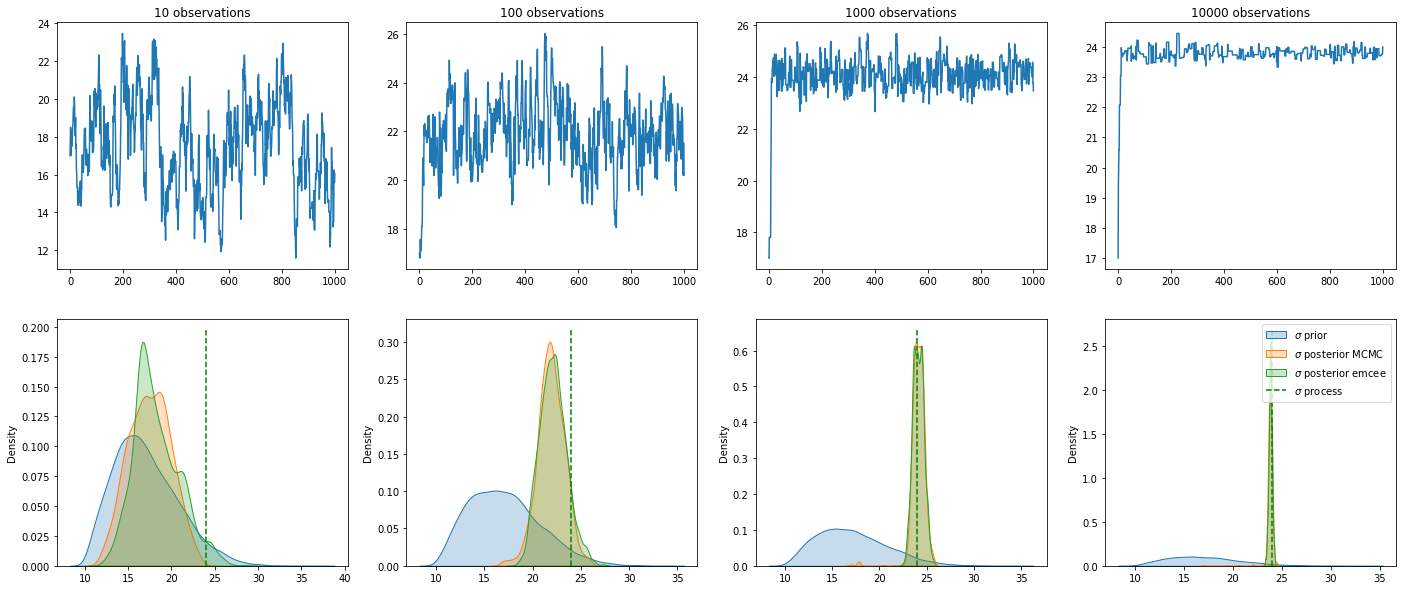

In [59]:
num_data = [10,100,1000,10000]
fig, ax = plt.subplots(2,4, figsize=(24,10))
for i, n in enumerate(num_data):
    # run the chain
    chain_bayes_sigma, rate_sigma = mcmc_sigma(log_sigma_posterior, data=bayes_data[:n], chain_length=1000, chain_start=17)
    
    # show the trace
    ax[0,i].plot(np.arange(len(chain_bayes_sigma)), chain_bayes_sigma)
    ax[0,i].set_title(f'{n} observations')
    
    # show the prior and posterior dists
    sns.kdeplot(x=scipy.stats.weibull_min(2, loc=10, scale=8).rvs(10000), fill=True, label='$\sigma$ prior', ax=ax[1, i])
    sns.kdeplot(x=chain_bayes_sigma, fill=True, label='$\sigma$ posterior MCMC', ax=ax[1, i])

    # run MCMC using emcee package for comparison
    sampler = emcee.EnsembleSampler(nwalkers=2, ndim=1, log_prob_fn=log_sigma_posterior, args=[bayes_data[:n], 13, 2, 10, 8])
    sampler.run_mcmc([[17.4],[20.1]], 2000)
    sns.kdeplot(x=sampler.get_chain(flat=True).flatten()[200:], fill=True, label='$\sigma$ posterior emcee', ax=ax[1, i])
    
    ax[1,i].vlines(24, *ax[1, i].get_ylim(), 'g', '--', label='$\sigma$ process')
    if i == len(num_data) - 1:
        ax[1,i].legend()

### Case 3: $\mu$ and $\sigma$ both unknown

In this final scenario we assume that we know neither $\mu$ nor $\sigma$ and we have the same priors as above for them, i.e.:

$$\begin{eqnarray} \mu &\sim& Normal \\ \sigma &\sim& Weibull \end{eqnarray}$$

#### Posterior

We want to evaluate the bivariate posterior:
    
$$p(\mu, \sigma | data) \sim p(data|\mu,\sigma)*p(\mu,\sigma)$$

Our priors on $\mu$ and $\sigma$ are independent so $p(\mu,\sigma)=p(\mu)*p(\sigma)$. And therefore we need to evaluate:

$$f(\mu, \sigma)=p(data|\mu,\sigma)*p(\mu)*p(\sigma)$$

This does not correspond to a known distribution we can directly draw from. **We need to use 2D MCMC**.

Let's try to use a Gibbs sampler, meaning we will need to draw from the conditionals.

**Conditional distribution of $\mu$**

$f(\mu|\sigma) \sim p(data|\mu,\sigma)*p(\mu)$

This is case 1 scenario: the $\sigma$ value is fixed and we have conjugacy between two Normal distributions.

$f(\mu|\sigma) \sim N(\mu_{1},\sigma_{1})$

where, with $n$=len(data):

$\sigma_{1}^{2} = \left(\frac{1}{\sigma_{0}^{2}} + \frac{n}{\sigma^{2}}\right)^{-1}$

$\mu_{1} = \sigma_{1}^{2}\left(\frac{\mu_{0}}{\sigma_{0}^{2}} + \frac{n<data>}{\sigma^{2}}\right)$


We can reuse the `mu_posterior_sample()` function we defined earlier.

**Conditional distribution of $\sigma$**

$f(\sigma|\mu) \sim p(data|\mu,\sigma)*p(\sigma)$

This is case 2 scenario: there is no direct way to sample from this conditinal and we'll use MCMC.

#### Hybrid Gibbs sampler

One posterior can be sampled directly but the other rely on MCMC, so our sampler is a hybrid Gibbs sampler - or "Metropolis within Gibbs" sampler. For $p(\sigma|\mu, data)$ conditional we're going to use the same proposal distribution and proposal width as in case 2.

In [60]:
def mcmc_hybrid_gibbs(data, cond_mu_sampler, log_cond_sigma, chain_length, chain_start):
    n_sigma_accepted = 0
    current = chain_start
    out = [current]
    for i in range(chain_length):
        proposed = current.copy()

        # mu can be updated directly
        proposed[0] = cond_mu_sampler(data, sigma=proposed[1], m0=30, s0=3, size=1)[0]        

        # sigma needs to rely on a Metropolis step (this is the "MCMC within MCMC" bit)
        # draw proposed_sigma from a truncated norm centered on current sigma
        sigma_current = proposed[1]
        sigma_proposed = scipy.stats.truncnorm(a=10.01 - sigma_current, b=np.inf, loc=sigma_current, scale=1).rvs(1)[0]

        # compute log-probabilities for current and proposed sigma values (using the just updated mu)
        log_p_current = log_cond_sigma(sigma_current, data, mu=proposed[0], c=2, loc=10, scale=8)
        log_p_proposed = log_cond_sigma(sigma_proposed, data, mu=proposed[0], c=2, loc=10, scale=8)

        # account for asymmetry of proposal dist
        ppc = scipy.stats.truncnorm(a=10.01 - sigma_current, b=np.inf, loc=sigma_current, scale=1).logpdf(sigma_proposed)
        pcp = scipy.stats.truncnorm(a=10.01 - sigma_proposed, b=np.inf, loc=sigma_proposed, scale=1).logpdf(sigma_current)

        # accept proposed value with probability p_proposed / p_current
        if np.log(scipy.stats.uniform(0, 1).rvs(1)[0]) < (log_p_proposed + pcp - (log_p_current + ppc)):
            proposed[1] = sigma_proposed
            n_sigma_accepted += 1

        # update trace
        out.append(proposed)
        current = proposed.copy()

    return np.array(out), n_sigma_accepted/(chain_length-1)

We can now run our sampler as usual. Let's see how it looks:

In [61]:
chain_hybrid, rate_sigma = mcmc_hybrid_gibbs(bayes_data[:100], cond_mu_sampler=mu_posterior_sample, log_cond_sigma=log_sigma_posterior, chain_length=1000, chain_start=[30,17])

In [62]:
def show_chains_2_hybrid(chain_hybrid):
    g = sns.JointGrid(height=8)

    # plot 2D MCMC chain
    sns.scatterplot(x=chain_hybrid[:,0], y=chain_hybrid[:,1], alpha=0.5, ax=g.ax_joint)
    
    # add actual process parameters references
    g.ax_joint.vlines(12.5, 10, 35, 'g', '--')
    g.ax_joint.hlines(24, 0, 30, 'g', '--')

    # prettify axes
    g.ax_joint.set_xlabel('$\mu$', fontsize='x-large')
    g.ax_joint.set_ylabel('$\sigma$', fontsize='x-large')

    # plot mu prior and posterior
    sns.kdeplot(x=scipy.stats.norm(loc=30, scale=3).rvs(10000), fill=True, ax=g.ax_marg_x, label='$\mu$ prior')
    sns.kdeplot(x=chain_hybrid[:,0], fill=True, ax=g.ax_marg_x, label='$\mu$ posterior')
    g.ax_marg_x.legend()

    # plot mu prior and posterior
    sns.kdeplot(y=scipy.stats.weibull_min(2, loc=10, scale=8).rvs(10000), fill=True, ax=g.ax_marg_y, label='$\sigma$ prior')
    sns.kdeplot(y=chain_hybrid[:,1], fill=True, ax=g.ax_marg_y, label='$\sigma$ posterior')
    g.ax_marg_y.legend()

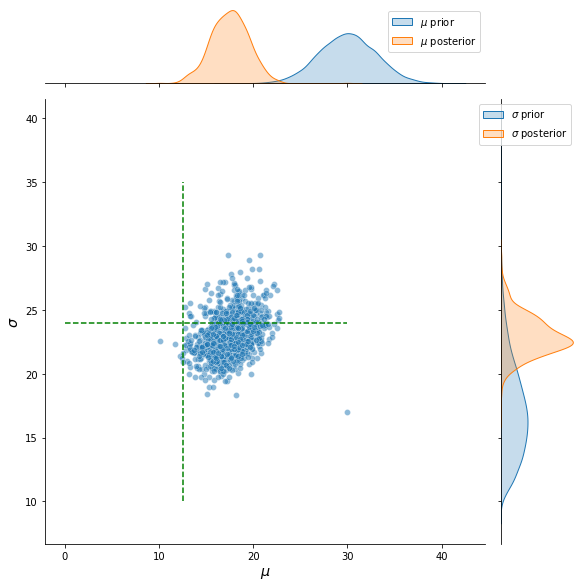

In [63]:
show_chains_2_hybrid(chain_hybrid)

**Note**: even though our priors on $\mu$ and $\sigma$ were independent, their posterior distributions are not. Our posterior here is a 2D posterior (which is different than 2 1D posteriors), so talking about "$\mu$ posterior" now really means "$\mu$ posterior marginalised over $\sigma$" (and vice versa). This is intuitive but worth bearing in mind.

Now we run our sampler for different amount of observations available and we'll plot the traces and distribution for both $\mu$ and $\sigma$.

In [64]:
def show_hybrid_mcmc():
    num_data = [10,100,1000,10000]
    fig, ax = plt.subplots(5,4, figsize=(24,25))
    for i, n in enumerate(num_data):
        # run the chain
        chain, rate_sigma = mcmc_hybrid_gibbs(bayes_data[:n], cond_mu_sampler=mu_posterior_sample, log_cond_sigma=log_sigma_posterior, chain_length=1000, chain_start=[30,17])

        # show scatter
        sns.scatterplot(x=chain[:,0], y=chain[:,1], ax=ax[0,i])

        # add actual process parameters references
        ax[0,i].vlines(12.5, *ax[0, i].get_xlim(), 'g', '--')
        ax[0,i].hlines(24, *ax[0, i].get_ylim(), 'g', '--')
        
        # prettify axes
        ax[0,i].set_xlabel('$\mu$', fontsize='x-large')
        ax[0,i].set_ylabel('$\sigma$', fontsize='x-large')
        ax[0,i].set_title(f'{n} observations')

        # show trace mu
        ax[1,i].plot(np.arange(len(chain[:,0])), chain[:,0], alpha=0.5, label='$\mu$ trace', c='y')
        ax[1,i].legend()

        # show mu prior and posterior dists
        sns.kdeplot(x=scipy.stats.norm(loc=30, scale=3).rvs(10000), fill=True, ax=ax[2, i], label='$\mu$ prior')
        sns.kdeplot(x=chain[:,0], fill=True, label='$\mu$ posterior (marginalised)', ax=ax[2, i], color='y')
        ax[2,i].vlines(12.5, *ax[2, i].get_ylim(), 'g', '--', label='$\mu$ process')
        ax[2,i].set_title(f'{n} observations')
        ax[2,i].legend()

        # show trace sigma
        ax[3,i].plot(np.arange(len(chain[:,1])), chain[:,1], alpha=0.5, label='$\sigma$ trace', c='y')
        ax[3,i].legend()

        # show mu prior and posterior dists
        sns.kdeplot(x=scipy.stats.weibull_min(2, loc=10, scale=8).rvs(10000), fill=True, ax=ax[4, i], label='$\sigma$ prior')
        sns.kdeplot(x=chain[:,1], fill=True, label='$\sigma$ posterior (marginalised)', ax=ax[4, i], color='y')
        ax[4,i].vlines(24, *ax[4, i].get_ylim(), 'g', '--', label='$\sigma$ process')
        ax[4,i].legend()

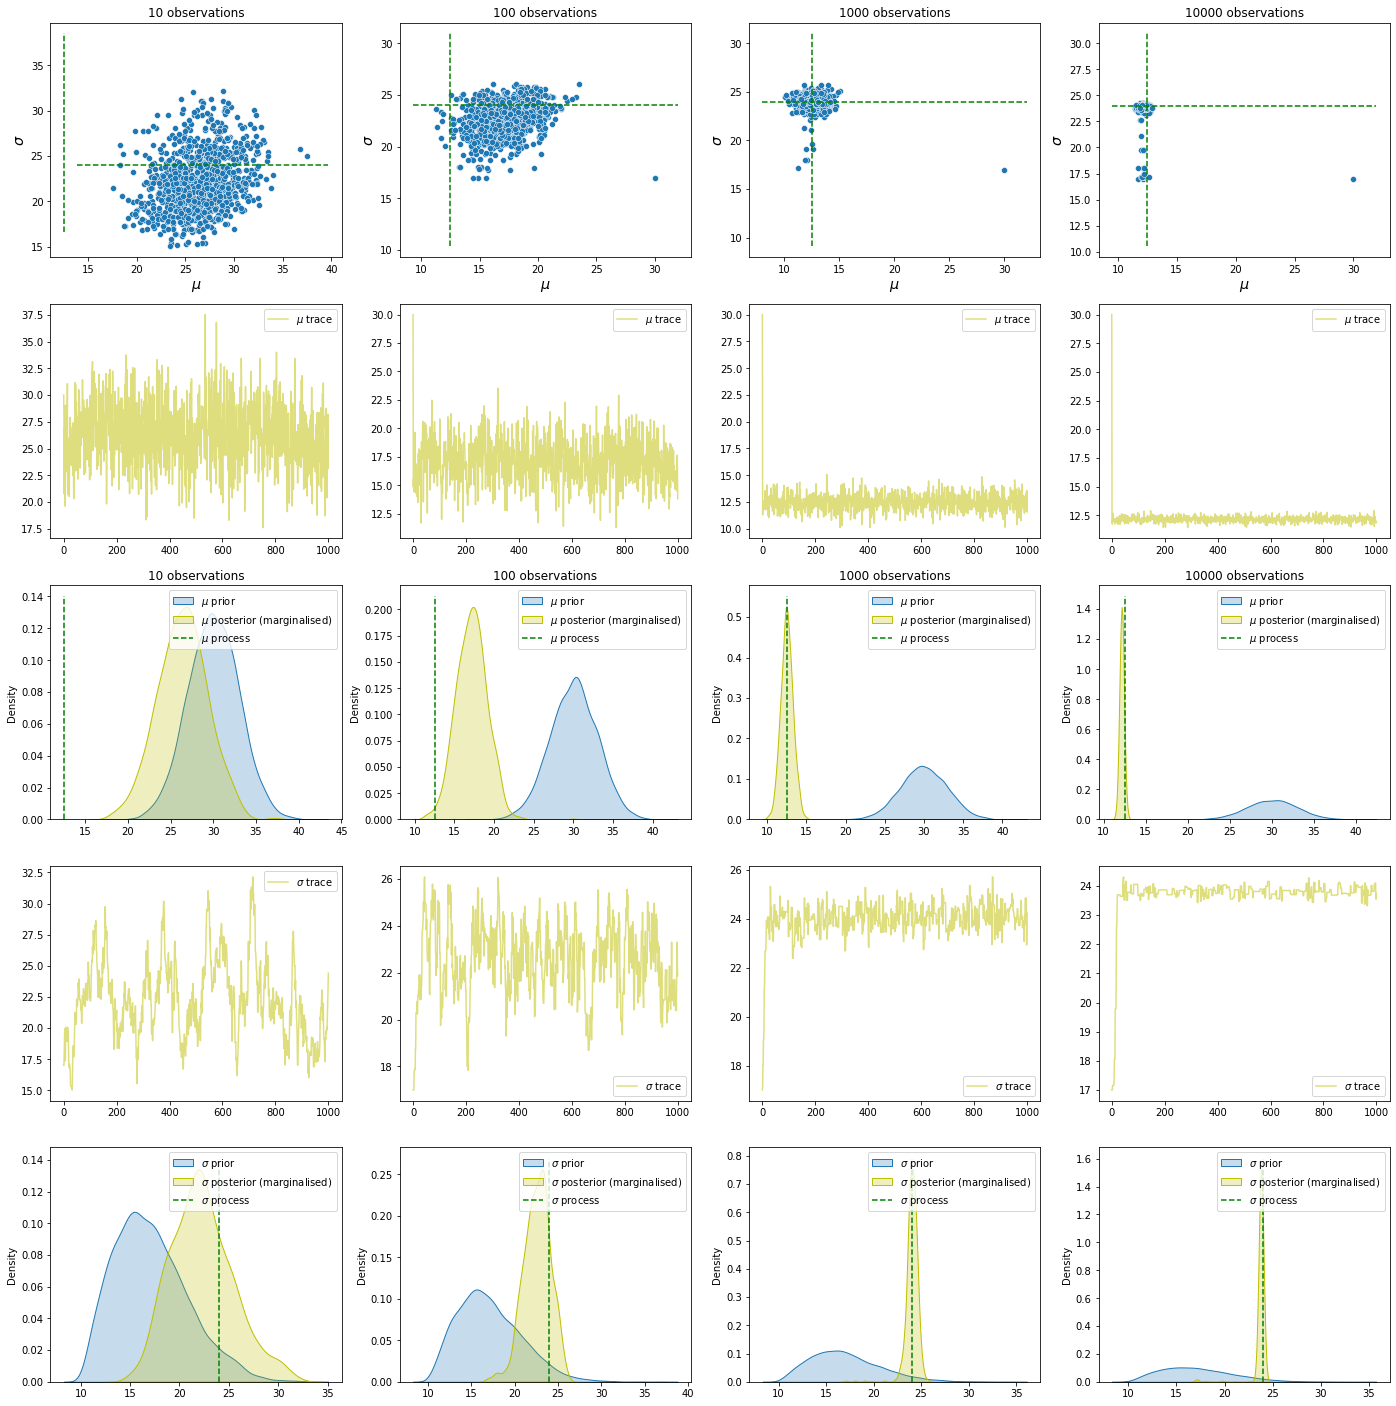

In [65]:
show_hybrid_mcmc()

That's pretty nice: as we get more data, we're narrowing the bivariate posterior around the actual values of the process parameters.

---

## Computing the posterior predictive distribution

This correponds to the probability of observing a new value $x$, given our model, initial prior and the already observed $data$:

$$p(x|data) = \int p(x|\theta)*p(\theta|data)d\theta$$

This is fairly easy to estimate by repetitively sampling via the following steps:
- draw $\theta_{i}$ from $p(\theta|data)$ (the posterior distribution)
- draw $x_{i}$ from $p(x|\theta_{i})$ (the model)

The obtained $\{x_{i}\}$ are distributed according to $p(x|data)$. That's because the above amounts to sampling from $p(x,\theta|data)$ and marginalising over $\theta$.

**Example**

Let's take the simple example corresponding to case 1 above, where we use a normal model with a known sigma ($\sigma_{known}=24$) and a normal prior with parameters $\mu_{0}$ and $\sigma_{0}$:
- $p(x|\mu) = N(\mu, \sigma_{known})$
- $p(\mu) = N(\mu_{0}, \sigma_{0})$

In this simple case we've seen that $\mu$ posterior is also a normal $p(\mu|data) \sim N(\mu_{1},\sigma_{1})$ where, with $n$=len(data), $\sigma_{1}^{2} = \left(\frac{1}{\sigma_{0}^{2}} + \frac{n}{\sigma^{2}}\right)^{-1}$ and $\mu_{1} = \sigma_{1}^{2}\left(\frac{\mu_{0}}{\sigma_{0}^{2}} + \frac{n<data>}{\sigma^{2}}\right)$.

As it turns out the predictive posterior is (perhaps unsurprisingly) also a normal: $p(x|data) \sim N(\mu_{1},\sqrt{\sigma_{1}^{2} + \sigma_{known}^{2}})$.

So let's compute the posterior predictive distribution by sampling from $\mu$ posterior using MCMC and let's compare the results to this analytical solution.

First we build the posterior chain:

In [66]:
mu_posterior_chain, mu_rate = mcmc_mu(log_mu_posterior, bayes_data, chain_length=20000, chain_start=30)

And then to sample from it efficiently we want to:
- discard the initial burn-in
- avoid drawing correlated values (thinning)

Let's look at the trace and the autocorrelation plots to get a sense of what would be sensible values for the burn-in and the thinning frequency.

Text(0, 0.5, 'correlation coefficient')

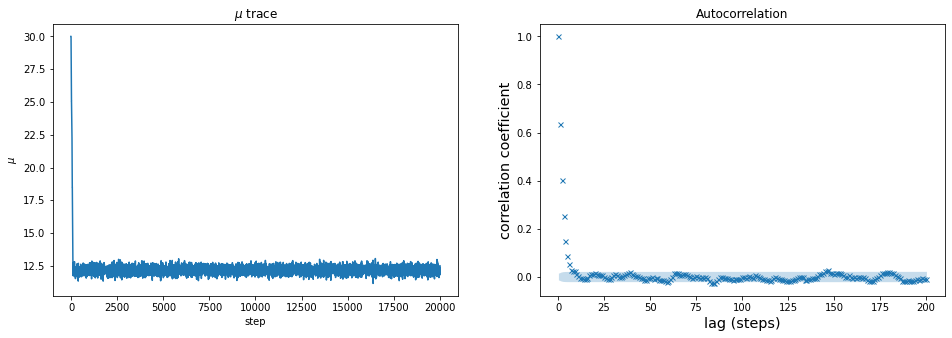

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].plot(np.arange(len(mu_posterior_chain)), mu_posterior_chain)
ax[0].set_xlabel('step')
ax[0].set_ylabel('$\mu$')
ax[0].set_title('$\mu$ trace')

plot_acf(mu_posterior_chain[100:],ax=ax[1], zero=100, lags=200, use_vlines=False, marker='x')
ax[1].set_xlabel('lag (steps)', fontsize='x-large')
ax[1].set_ylabel('correlation coefficient', fontsize='x-large')

Let's obtain our $\{\mu_{i}\}$ samples from the posterior $p(\mu|data)$ by discarding the first 100 steps and taking every 20th element in the chain:

In [68]:
mu_samples = mu_posterior_chain[100::20]

Then let's draw an element from $p(x | \mu_{i})$ for each $\mu_{i}$ to get our $\{x_{i}\}$ samples:

In [69]:
x_samples = np.array([scipy.stats.norm(m, 24).rvs(1) for m in mu_samples]).flatten()

To be clear, this is what we've done:

Text(0.5, 1.0, 'posterior predictive $p(x|data)$')

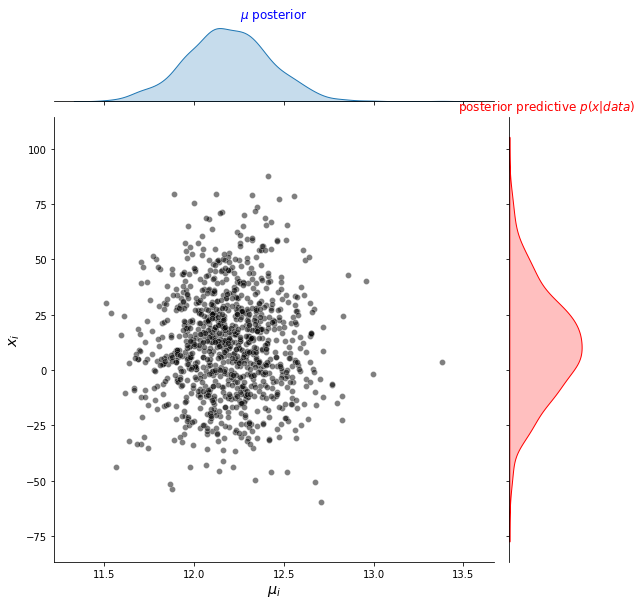

In [70]:
g = sns.JointGrid(height=8)

# plot 2D chain
sns.scatterplot(x=mu_samples, y=x_samples, alpha=0.5, ax=g.ax_joint, color='k')
g.ax_joint.set_xlabel('$\mu_{i}$', fontsize='x-large')
g.ax_joint.set_ylabel('$x_{i}$', fontsize='x-large')

# plot mu posterior
sns.kdeplot(x=mu_samples, fill=True, ax=g.ax_marg_x)
g.ax_marg_x.set_title('$\mu$ posterior', color='b')

# plot posterior predictive
sns.kdeplot(y=x_samples, fill=True, ax=g.ax_marg_y, color='r')
g.ax_marg_y.set_title('posterior predictive $p(x|data)$', color='r')

And let's compare their distribution to the theoretical posterior predictive distribution:

In [71]:
def show_posterior_predictive(data, x_samples, sigma=24, m0=30, s0=3):
    fig, ax = plt.subplots(figsize=(8,5))

    # MCMC-based
    sns.kdeplot(x=x_samples, fill=True, ax=ax, label='MCMC')

    # theoretical
    n = len(data)
    s1 = np.sqrt(1/(1/s0**2  + n/sigma**2))
    m1 = s1**2*(m0/s0**2 + n*np.mean(data)/sigma**2)
    sns.kdeplot(x=scipy.stats.norm(m1, np.sqrt(s1**2 + sigma**2)).rvs(len(x_samples)), fill=True, ax=ax, label='theoretical')
    ax.set_title('posterior predictive $p(x|data)$')
    ax.legend()

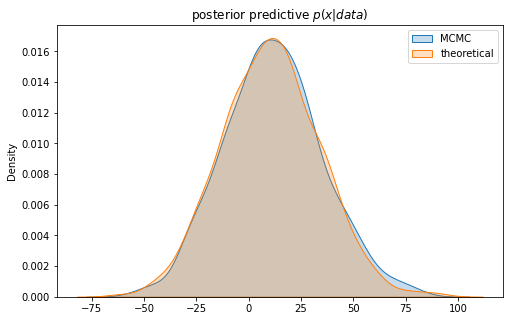

In [72]:
show_posterior_predictive(bayes_data, x_samples)

Looking pretty good! The bigger the $\{x+{i}\}$ samples, the better the match (and we can speed speed up that process by drawing more than 1 value for each $\mu_{i}$).

---

The end for now. I might update this notebook to add a section on MCMC and integration (and go over methods such as "importance sampling").